In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

device=torch.device("cuda")

In [2]:
import numpy as np
train_st=np.load('./processed_data/train/train.npy')
train_lab=np.load('./processed_data/train/train_labels.npy')
test_st=np.load('./processed_data/test/test.npy')
test_lab=np.load('./processed_data/test/test_labels.npy')

In [29]:
train_lab[:,1].mean()

np.float64(37.346037195586)

In [3]:
def log_standardize(x, mean=None, std=None):
    """
    Apply log1p transform, then standardize.
    
    Parameters
    ----------
    x : array-like
        Input values (e.g., ozone concentrations).
    mean : float, optional
        Mean from training set. If None, computed from x.
    std : float, optional
        Std from training set. If None, computed from x.
    
    Returns
    -------
    x_scaled : np.ndarray
        Log-transformed + standardized values.
    mean : float
        Mean used for scaling (store this for test data).
    std : float
        Std used for scaling (store this for test data).
    """
    x_log = np.log1p(x)
    
    if mean is None:
        mean = x_log.mean()
    if std is None:
        std = x_log.std()
        
    
    x_scaled = (x_log - mean) / std
    return x_scaled, mean, std

In [4]:
no2_train=np.load('./processed_data/train/MM_NO2_index_train.npy')
so2_train=np.load('./processed_data/train/MM_SO2_index_train.npy')
co_train=np.load('./processed_data/train/MM_CO_index_train.npy')
hcho_train=np.load('./processed_data/train/MM_HCHO_index_train.npy')
o3_train=np.load('./processed_data/train/MM_O3_index_train.npy')
h2o_train=np.load('./processed_data/train/MM_H20_index_train.npy')
cloud_train=np.load('./processed_data/train/MM_cloud_index_train.npy')
ch4_train=np.load('./processed_data/train/MM_CH4_index_train.npy')
aerosol_train=np.load('./processed_data/train/MM_aerosol_index_22-25_train.npy')

In [5]:
no2_test=np.load('./processed_data/test/MM_NO2_index_test.npy')
so2_test=np.load('./processed_data/test/MM_SO2_index_test.npy')
co_test=np.load('./processed_data/test/MM_CO_index_test.npy')
hcho_test=np.load('./processed_data/test/MM_HCHO_index_test.npy')
o3_test=np.load('./processed_data/test/MM_O3_index_test.npy')
h2o_test=np.load('./processed_data/test/MM_H20_index_test.npy')
cloud_test=np.load('./processed_data/test/MM_cloud_index_test.npy')
ch4_test=np.load('./processed_data/test/MM_CH4_index_test.npy')
aerosol_test=np.load('./processed_data/test/MM_aerosol_index_22-25_test.npy')

In [6]:
train_sat=np.stack((no2_train,so2_train,co_train,hcho_train,o3_train,h2o_train,cloud_train,ch4_train,aerosol_train),axis=1)
train_sat.shape


(730, 9, 11, 12)

In [7]:
test_sat=np.stack((no2_test,so2_test,co_test,hcho_test,o3_test,h2o_test,cloud_test,ch4_test,aerosol_test),axis=1)
test_sat.shape

(366, 9, 11, 12)

In [8]:
labels_scaled,train_mean,train_std=log_standardize(train_lab)
testlabels_scaled,_,_=log_standardize(test_lab,train_mean,train_std)

In [9]:
train=np.concat([train_st,labels_scaled],axis=1)
test=np.concat([test_st,testlabels_scaled],axis=1)

In [10]:
def unfold_horizon(labels, station,satellite, horizon=24, input=24):
    labels = labels[input:]
    satellite_hourly_seq=satellite.unfold(dimension=0,size=input,step=1)
    station_seq=station.unfold(dimension=0,size=input,step=1)
    satellite_hourly_seq=satellite_hourly_seq[:-1,...]
    station_seq=station_seq[:-1,...]
    train_labels=labels.unfold(size=horizon,dimension=0,step=1)
    satellite_hourly_seq=satellite_hourly_seq[:-(horizon-1),...]
    station_seq=station_seq[:-(horizon-1),...]

    return train_labels,station_seq,satellite_hourly_seq

In [11]:
# broadcast to hourly frequency

train_sat_tensor=torch.tensor(train_sat,dtype=torch.float32).to(device)
train_sat_tensor=train_sat_tensor.repeat_interleave(24,dim=0)
train_sat_tensor.shape

torch.Size([17520, 9, 11, 12])

In [12]:
labels=torch.tensor(labels_scaled,dtype=torch.float32).to(device)
station=torch.tensor(train,dtype=torch.float32).to(device)

train_labels,station_seq,satellite_hourly_seq=unfold_horizon(labels,station,train_sat_tensor)
print(train_labels.shape,station_seq.shape,satellite_hourly_seq.shape)

torch.Size([17473, 2, 24]) torch.Size([17473, 11, 24]) torch.Size([17473, 9, 11, 12, 24])


In [13]:
test_sat_tensor=torch.tensor(test_sat,dtype=torch.float32).to(device)
test_sat_tensor=test_sat_tensor.repeat_interleave(24,dim=0)
test_sat_tensor.shape

torch.Size([8784, 9, 11, 12])

In [14]:
test_labels=torch.tensor(testlabels_scaled,dtype=torch.float32).to(device)
test_station=torch.tensor(test,dtype=torch.float32).to(device)

test_labels,test_station_seq,test_satellite_hourly_seq=unfold_horizon(test_labels,test_station,test_sat_tensor)
print(test_labels.shape,test_station_seq.shape,test_satellite_hourly_seq.shape)

torch.Size([8737, 2, 24]) torch.Size([8737, 11, 24]) torch.Size([8737, 9, 11, 12, 24])


In [15]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    """Refined CNN encoder for 9-channel satellite grids."""
    def __init__(self, in_channels=9, output_size=64, dropout=0.2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),   # → [B, 64, 1, 1]
            nn.Flatten()               # → [B, 64]
        )

        self.fc = nn.Sequential(
            nn.Linear(64, output_size),
            nn.LayerNorm(output_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

class MLPProj(nn.Module):
    def __init__(self, in_dim=18, hidden=128, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden, out_dim),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class FusionModel(nn.Module):
    """Fuses CNN-encoded satellite data with station features, then forecasts pollutants."""
    def __init__(
        self,
        sat_channels=2,
        station_features=18,
        cnn_out=64,
        out_dim=32,
        lstm_hidden=64,
        lstm_layers=1,
        dropout=0.15,
        hidden_size=128,
    ):
        super().__init__()

        # Choose encoder
        self.cnn_o3 = CNNEncoder(in_channels=9,output_size=cnn_out)

        lstm_input_size = out_dim+cnn_out
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.station_proj=MLPProj(station_features,hidden=hidden_size,out_dim=out_dim)
        # Heads for O3 and NO2
        self.head_O3 = nn.Linear(2*lstm_hidden, 24)
        self.head_NO2 = nn.Linear(2*lstm_hidden, 24)

    def forward(self, sat_x, station_x):
        """
        sat_x: [batch, seq_len, channels, H, W]
        station_x: [batch, seq_len, station_features]
        """
        batch_size, seq_len, _, _, _ = sat_x.shape

        # Encode each time step
        cnn_embeds = []
        for t in range(seq_len):
            grid = sat_x[:, t, ...]   # [batch, 1, 9, 10]
        
            sat_feat = self.cnn_o3(grid)     # [batch, 32

            cnn_embeds.append(sat_feat)

    
        cnn_embeds = torch.stack(cnn_embeds, dim=1)
        
        station_x=self.station_proj(station_x)

        lstm_in = torch.cat((cnn_embeds, station_x), dim=-1)

        lstm_out, _ = self.lstm(lstm_in)  # [B, seq_len, 2*lstm_hidden]
        last_out = lstm_out[:, -1]        # [B, 2*lstm_hidden]
        pred_o3 = self.head_O3(last_out).unsqueeze(-1)  # [B, 24]
        pred_no2 = self.head_NO2(last_out).unsqueeze(-1) 

        return torch.cat((pred_no2,pred_o3), dim=-1) # [batch, 2]


In [16]:
sat_data=satellite_hourly_seq.permute(0,4,1,2,3) #[17508, 12, 2, 9, 10])
station_data=station_seq.permute(0,2,1) #[17508, 16, 12]
labels=train_labels.permute(0,2,1) # ([17508, 2])

print(sat_data.shape,station_data.shape,labels.shape)

# Create Dataset and DataLoader
dataset = TensorDataset(sat_data, station_data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


model=FusionModel(
    sat_channels=9,
    station_features=11,
    cnn_out=64,
    out_dim=64,
    lstm_hidden=128,
    lstm_layers=1,
    hidden_size=128,
).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



# ======================
# Training Loop
# ======================
epochs = 25

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for sat_batch, station_batch, y_batch in dataloader:
        sat_batch = sat_batch.to(device, dtype=torch.float32)
        station_batch = station_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(sat_batch, station_batch)

        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * sat_batch.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")






torch.Size([17473, 24, 9, 11, 12]) torch.Size([17473, 24, 11]) torch.Size([17473, 24, 2])
Epoch [1/25] Loss: 0.5107
Epoch [2/25] Loss: 0.4603
Epoch [3/25] Loss: 0.4408
Epoch [4/25] Loss: 0.4297
Epoch [5/25] Loss: 0.4233
Epoch [6/25] Loss: 0.4076
Epoch [7/25] Loss: 0.3946
Epoch [8/25] Loss: 0.3851
Epoch [9/25] Loss: 0.3747
Epoch [10/25] Loss: 0.3671
Epoch [11/25] Loss: 0.3565
Epoch [12/25] Loss: 0.3487
Epoch [13/25] Loss: 0.3409
Epoch [14/25] Loss: 0.3336
Epoch [15/25] Loss: 0.3269
Epoch [16/25] Loss: 0.3216
Epoch [17/25] Loss: 0.3154
Epoch [18/25] Loss: 0.3107
Epoch [19/25] Loss: 0.3049
Epoch [20/25] Loss: 0.3005
Epoch [21/25] Loss: 0.2947
Epoch [22/25] Loss: 0.2917
Epoch [23/25] Loss: 0.2881
Epoch [24/25] Loss: 0.2835
Epoch [25/25] Loss: 0.2821


In [17]:
def compute_metrics_separate(y_true, y_pred):
    """
    Compute MAE, RMSE, R² for each pollutant separately (NO2, O3).
    y_true, y_pred: [N, 2] tensors
    Returns:
        metrics = {
            "NO2": {"mae": ..., "rmse": ..., "r2": ...},
            "O3": {"mae": ..., "rmse": ..., "r2": ...}
        }
    """

    metrics = {}

    for i, name in enumerate(["NO2", "O3"]):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        mae = torch.mean(torch.abs(y_t - y_p))
        mse = torch.mean((y_t - y_p) ** 2)
        rmse = torch.sqrt(mse)

        y_mean = torch.mean(y_t)
        ss_tot = torch.sum((y_t - y_mean) ** 2)
        ss_res = torch.sum((y_t - y_p) ** 2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)

        metrics[name] = {
            "mae": mae.item(),
            "rmse": rmse.item(),
            "r2": r2.item()
        }

    return metrics



In [18]:
sat_data=test_satellite_hourly_seq.permute(0,4,1,2,3) #[17508, 12, 2, 9, 10])
station_data=test_station_seq.permute(0,2,1) #[17508, 16, 12]
# test_labels_scaled = (test_labels - labels_mean) / labels_std
labels=test_labels.permute(0,2,1) # ([17508, 2])

test_dataset = TensorDataset(sat_data, station_data, labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
val_loss = 0.0
all_preds, all_labels = [], []

with torch.no_grad():
    for sat_batch, station_batch, y_batch in test_loader:
        sat_batch = sat_batch.to(device, dtype=torch.float32)
        station_batch = station_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.float32)

        preds = model(sat_batch, station_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * sat_batch.size(0)

        all_preds.append(preds)
        all_labels.append(y_batch)

avg_val_loss = val_loss / len(test_loader.dataset)

# Metrics
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_preds_real = torch.expm1(all_preds * train_std + train_mean)
all_labels_real = torch.expm1(all_labels * train_std + train_mean)
metrics = compute_metrics_separate(all_labels_real, all_preds_real)


print(f"NO2  → MAE: {metrics['NO2']['mae']:.2f}  "
      f"RMSE: {metrics['NO2']['rmse']:.2f}  "
      f"R²: {metrics['NO2']['r2']:.3f}")

print(f"O3   → MAE: {metrics['O3']['mae']:.2f}  "
      f"RMSE: {metrics['O3']['rmse']:.2f}  "
      f"R²: {metrics['O3']['r2']:.3f}")

NO2  → MAE: 12.35  RMSE: 17.89  R²: 0.755
O3   → MAE: 14.65  RMSE: 20.91  R²: 0.666


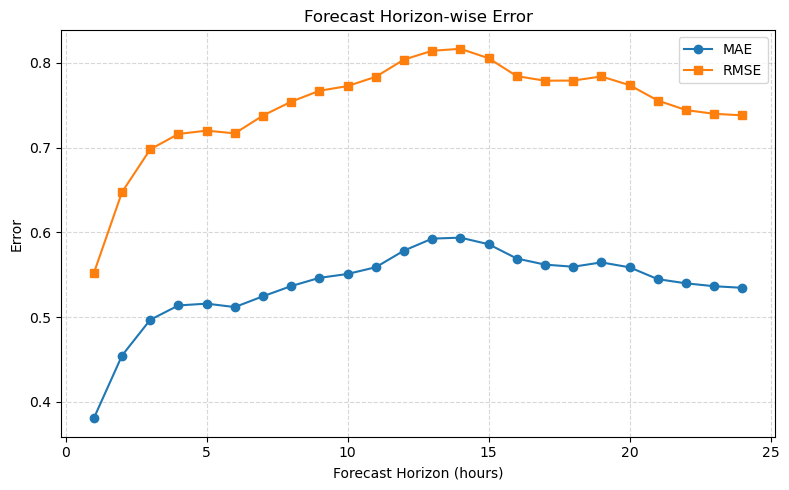

In [19]:
import torch
import matplotlib.pyplot as plt

# Assuming all_preds and all_labels are [N, horizon]
# and both are in **original (unscaled, unlogged)** space

horizons = all_preds.shape[1]
mae_per_h = []
rmse_per_h = []

for h in range(horizons):
    pred_h = all_preds[:, h]
    true_h = all_labels[:, h]

    err = pred_h - true_h
    mae = torch.mean(torch.abs(err)).item()
    rmse = torch.sqrt(torch.mean(err ** 2)).item()

    mae_per_h.append(mae)
    rmse_per_h.append(rmse)

# ---------------------
# Plot
# ---------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, horizons+1), mae_per_h, label='MAE', marker='o')
plt.plot(range(1, horizons+1), rmse_per_h, label='RMSE', marker='s')
plt.title('Forecast Horizon-wise Error')
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Error')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


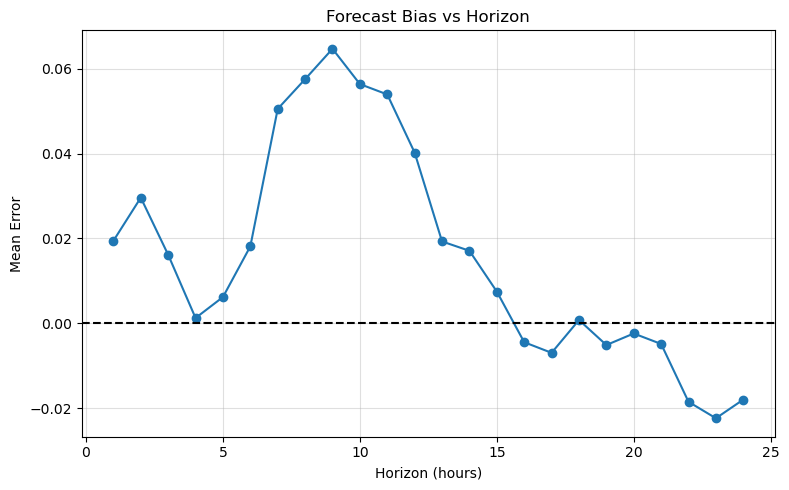

In [20]:
bias_per_h = []
for h in range(horizons):
    err = all_preds[:, h] - all_labels[:, h]
    bias_per_h.append(torch.mean(err).item())

plt.figure(figsize=(8,5))
plt.plot(range(1, horizons+1), bias_per_h, marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title("Forecast Bias vs Horizon")
plt.xlabel("Horizon (hours)")
plt.ylabel("Mean Error")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


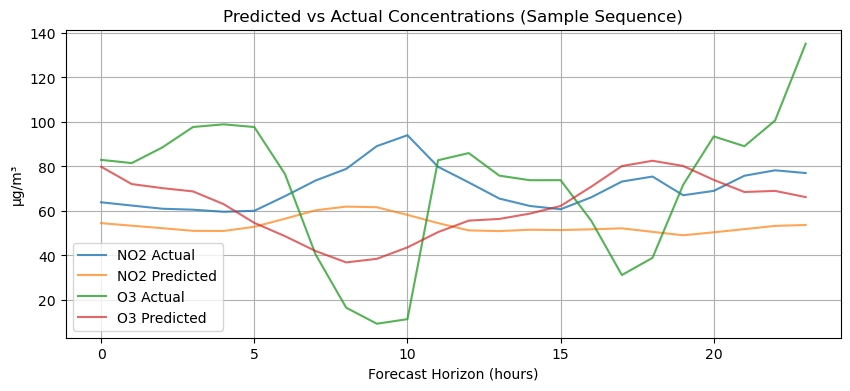

In [34]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(all_labels_real))  # random sample
plt.figure(figsize=(10,4))
plt.plot(all_labels_real[idx, :, 0].cpu(), label='NO2 Actual', alpha=0.8)
plt.plot(all_preds_real[idx, :, 0].cpu(), label='NO2 Predicted', alpha=0.7)
plt.plot(all_labels_real[idx, :, 1].cpu(), label='O3 Actual', alpha=0.8)
plt.plot(all_preds_real[idx, :, 1].cpu(), label='O3 Predicted', alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Concentrations (Sample Sequence)")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("µg/m³")
plt.grid(True)
plt.show()



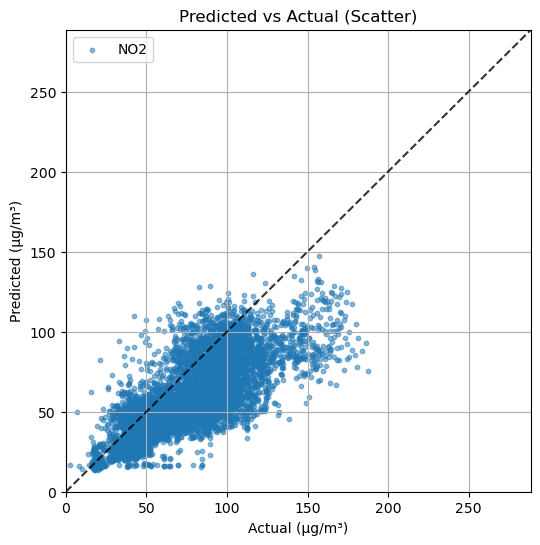

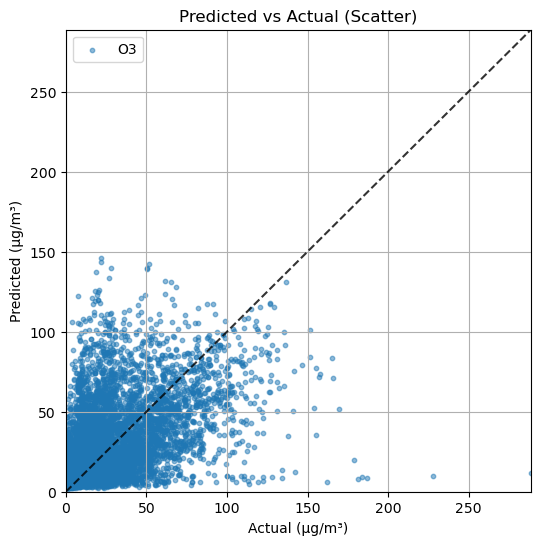

In [47]:
def plot_scatter(all_labels_real, all_preds_real,labels):
    for i in range(len(labels)):
        
        plt.figure(figsize=(6,6))
        plt.scatter(all_labels_real[:,23,i].cpu(), all_preds_real[:,23,i].cpu(), s=10, alpha=0.5, label=labels[i])
        lims = [0, max(all_labels_real[:,i].cpu().max(), all_preds_real[:,i].cpu().max())]
        plt.plot(lims, lims, 'k--', alpha=0.8)
        plt.xlim(lims)
        plt.ylim(lims)
        plt.xlabel("Actual (µg/m³)")
        plt.ylabel("Predicted (µg/m³)")
        plt.legend()
        plt.title("Predicted vs Actual (Scatter)")
        plt.grid(True)
        plt.show()

plot_scatter(all_labels_real, all_preds_real,labels=["NO2","O3"])


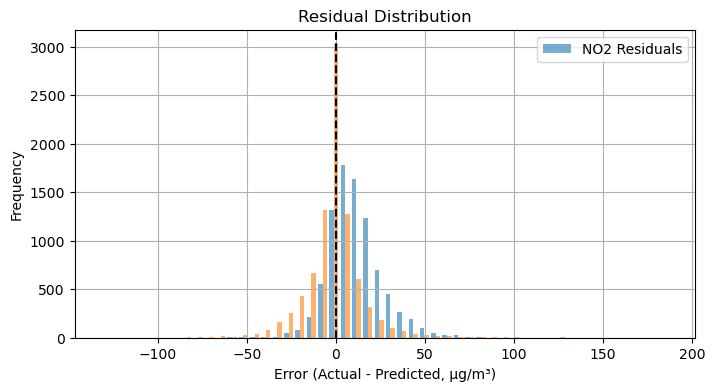

In [53]:
res_no2 = (all_labels_real[:,0] - all_preds_real[:,0]).cpu()
res_o3  = (all_labels_real[:,1] - all_preds_real[:,1]).cpu()

plt.figure(figsize=(8,4))
plt.hist(res_no2, bins=50, alpha=0.6, label='NO2 Residuals')
# plt.hist(res_o3, bins=50, alpha=0.6, label='O3 Residuals')
plt.axvline(0, color='k', linestyle='--')
plt.legend()
plt.title("Residual Distribution")
plt.xlabel("Error (Actual - Predicted, µg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


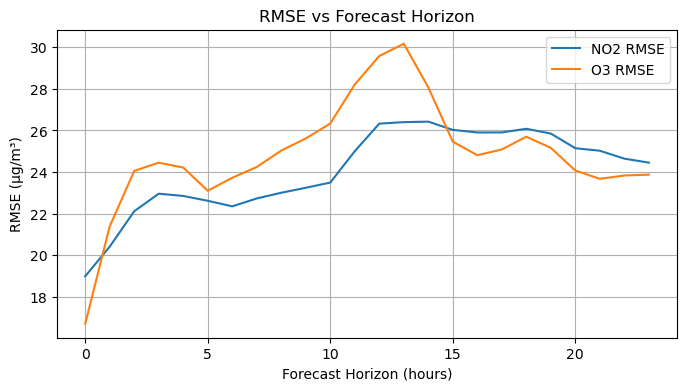

In [54]:
horizons = np.arange(all_preds_real.shape[1])  # 0..23 for 24h forecast

rmse_no2 = ((all_preds_real[:,:,0]-all_labels_real[:,:,0])**2).mean(dim=0).sqrt()
rmse_o3  = ((all_preds_real[:,:,1]-all_labels_real[:,:,1])**2).mean(dim=0).sqrt()

plt.figure(figsize=(8,4))
plt.plot(horizons, rmse_no2.cpu(), label='NO2 RMSE')
plt.plot(horizons, rmse_o3.cpu(), label='O3 RMSE')
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("RMSE (µg/m³)")
plt.title("RMSE vs Forecast Horizon")
plt.legend()
plt.grid(True)
plt.show()


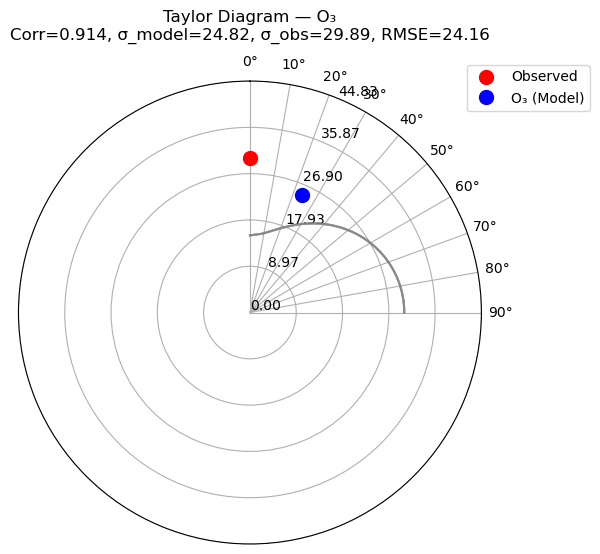

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def taylor_diagram(y_true, y_pred, label="O₃", ref_label="Observed"):
    """
    Draw a Taylor diagram comparing model predictions vs observations.
    y_true, y_pred: 1D numpy arrays
    """

    # Compute metrics
    std_ref = np.std(y_true)
    std_model = np.std(y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    # Convert correlation to polar angle
    theta = np.arccos(corr)

    # Figure setup
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)

    # Plot reference point (observed)
    ax.plot(0, std_ref, 'ro', label=ref_label, markersize=10)

    # Plot model point
    ax.plot(theta, std_model, 'bo', label=f"{label} (Model)", markersize=10)

    # Add RMSE contours
    rs = np.linspace(0, std_ref * 1.5, 100)
    ts = np.linspace(0, np.pi/2, 200)
    for r in np.linspace(0, std_ref * 1.5, 7):
        ax.plot(np.arccos(np.linspace(0, 1, 100)), np.sqrt(std_ref**2 + (rs**2) - 2*std_ref*rs*np.linspace(0, 1, 100)), color='gray', alpha=0.3)

    # Configure axes
    ax.set_thetagrids(np.arange(0, 91, 10))
    ax.set_rgrids(np.linspace(0, std_ref*1.5, 6))
    ax.set_ylim(0, std_ref*1.5)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    # Title and legend
    ax.set_title(f"Taylor Diagram — {label}\nCorr={corr:.3f}, σ_model={std_model:.2f}, σ_obs={std_ref:.2f}, RMSE={rmse:.2f}", pad=30)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05))

    plt.tight_layout()
    plt.show()


# === Example usage ===
o3_true = all_labels_real[:,:, 0].detach().cpu().numpy()
o3_pred = all_preds_real[:,:, 0].detach().cpu().numpy()
taylor_diagram(o3_true, o3_pred, label="O₃")
